# Wavelet Transformations for Hazelnut Defect Detection (hazelnut_1)

This notebook is a hands-on, educational walkthrough of 2D wavelet transforms and how they can help surface defects in hazelnut images.

**What you will do:**
- Explore the `data/hazelnut_1` dataset and preview samples.
- Learn how discrete wavelet transforms (DWT) decompose images.
- Compare wavelet families on the same image.
- Extract simple wavelet energy features and build a tiny anomaly detector.


## 0. Setup

If `PyWavelets` is missing, install it in your environment, then restart the kernel:

```bash
pip install PyWavelets
```


In [34]:
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import roc_auc_score

try:
    import pywt
except ImportError as exc:
    raise ImportError(
        "PyWavelets is required. Install with `pip install PyWavelets` and restart the kernel."
    ) from exc

SEED = 7
random.seed(SEED)
np.random.seed(SEED)

DATA_DIR = Path("data/hazelnut_1")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
GT_DIR = DATA_DIR / "ground_truth"

IMG_SIZE = (256, 256)

if not DATA_DIR.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_DIR}")

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


## 1. Dataset overview

In [35]:
EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def list_images(dir_path):
    return sorted([p for p in dir_path.iterdir() if p.suffix.lower() in EXTS])

train_good = list_images(TRAIN_DIR / "good")

test_classes = sorted([p.name for p in TEST_DIR.iterdir() if p.is_dir()])

test_counts = []
for cls in test_classes:
    paths = list_images(TEST_DIR / cls)
    test_counts.append({"split": "test", "class": cls, "count": len(paths)})

overview = pd.DataFrame(
    [{"split": "train", "class": "good", "count": len(train_good)}] + test_counts
)

overview


,split,class,count
0,train,good,391
1,test,crack,18
2,test,cut,17
3,test,good,40
4,test,hole,18
5,test,print,17


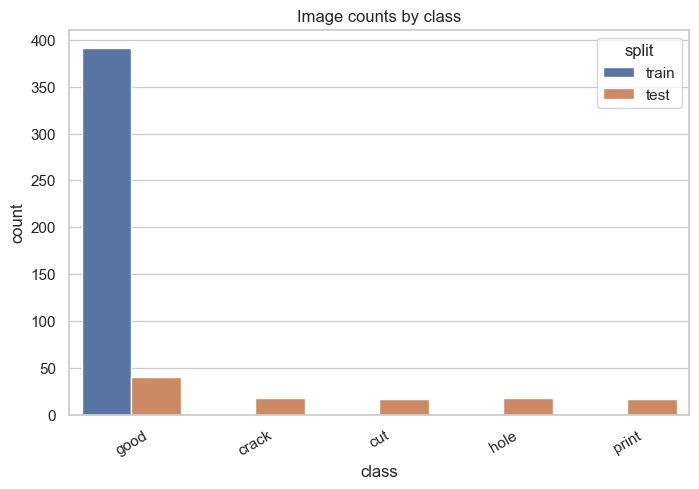

In [36]:
ax = sns.barplot(data=overview, x="class", y="count", hue="split")
ax.set_title("Image counts by class")
ax.set_xlabel("class")
ax.set_ylabel("count")
plt.xticks(rotation=30)
plt.show()


Showing greyscale, normalized images of both classes "good" and "bad"

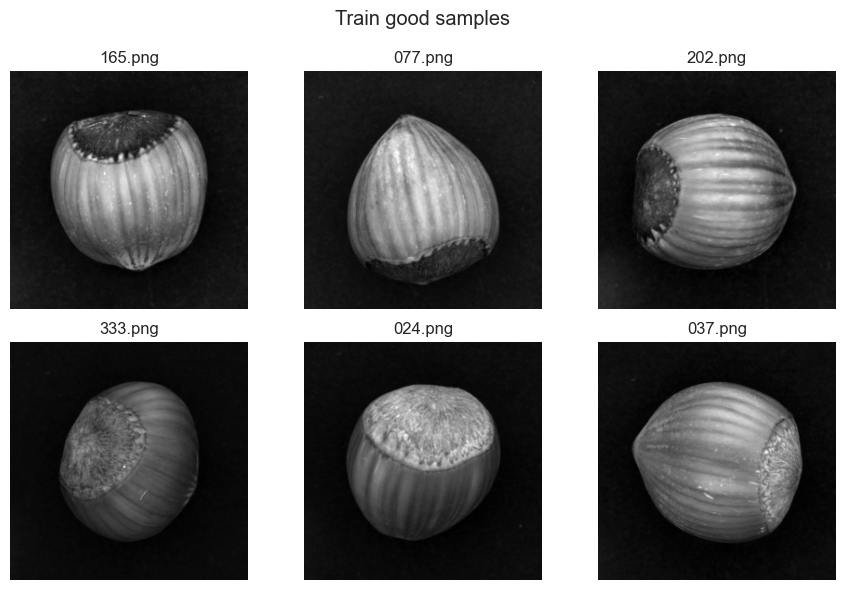

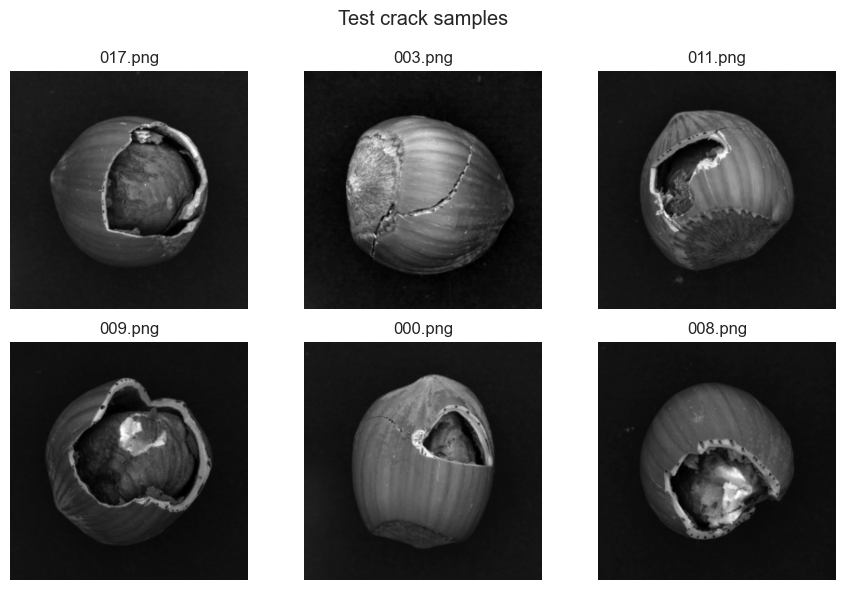

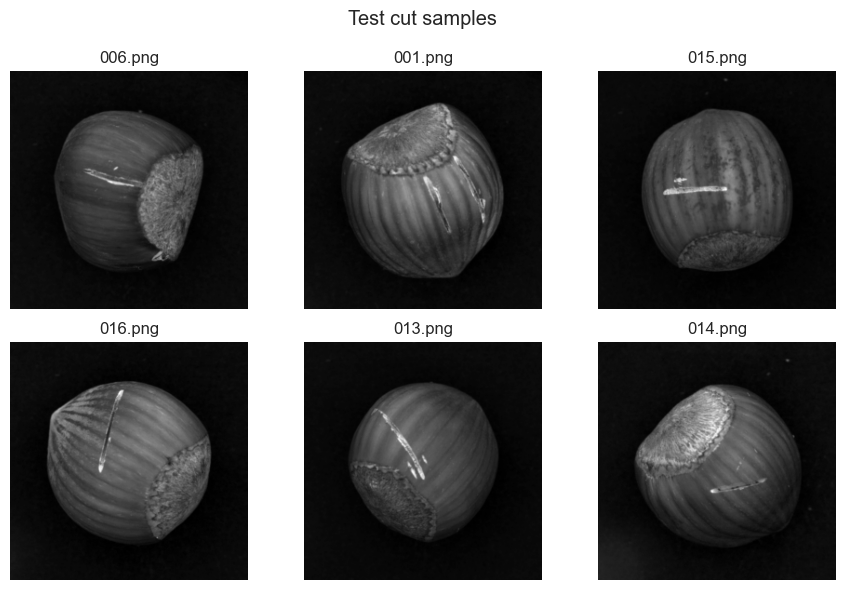

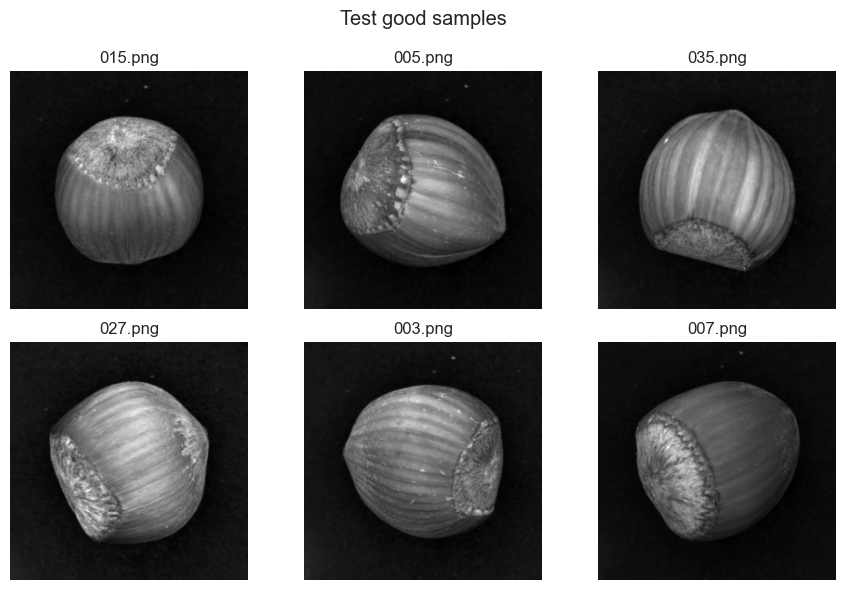

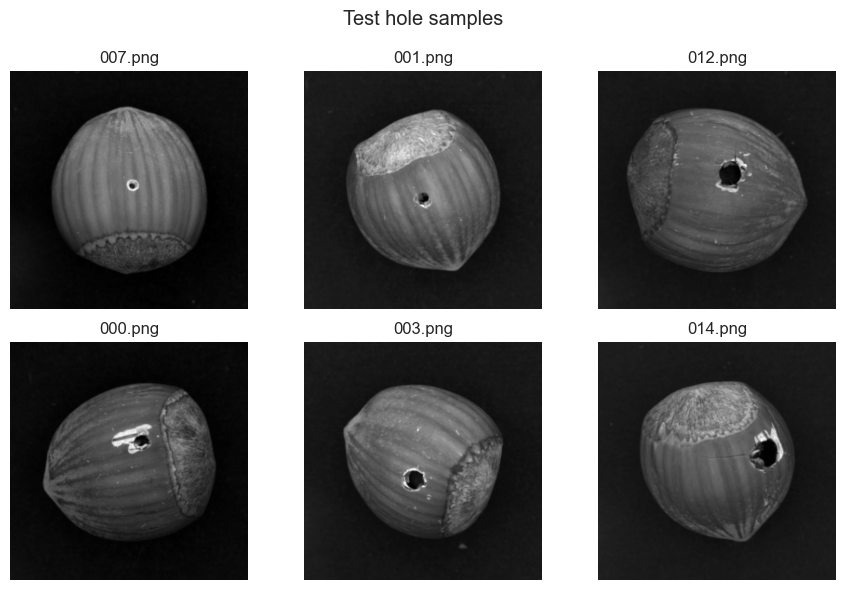

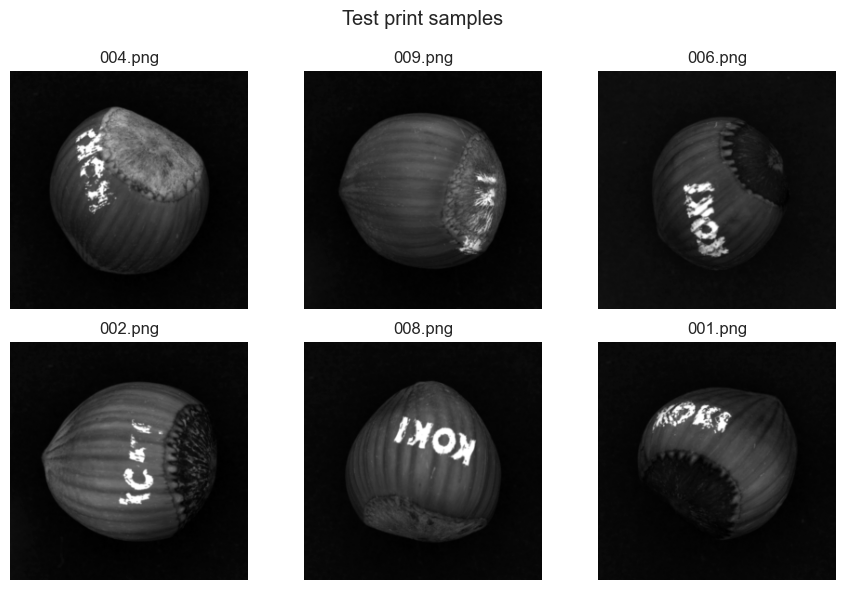

In [37]:
def load_image(path, size=IMG_SIZE, gray=True):
    img = Image.open(path)
    if gray:
        img = img.convert("L")
    if size is not None:
        img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr


def show_samples(paths, n=6, title=""):
    paths = random.sample(paths, min(n, len(paths)))
    cols = min(3, len(paths))
    rows = int(np.ceil(len(paths) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(-1)
    for ax, path in zip(axes, paths):
        img = load_image(path)
        ax.imshow(img, cmap="gray")
        ax.set_title(path.name)
        ax.axis("off")
    for ax in axes[len(paths):]:
        ax.axis("off")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_good, title="Train good samples")
for cls in test_classes:
    show_samples(list_images(TEST_DIR / cls), title=f"Test {cls} samples")


## 2. Wavelet basics

A 2D discrete wavelet transform (DWT) splits an image into:
- **Approximation (low-low)**: coarse structure.
- **Horizontal detail (high-low)**: vertical edges.
- **Vertical detail (low-high)**: horizontal edges.
- **Diagonal detail (high-high)**: fine diagonal texture.

These sub-bands are powerful for spotting surface defects that appear as localized high-frequency changes.


Sample: data/hazelnut_1/train/good/292.png


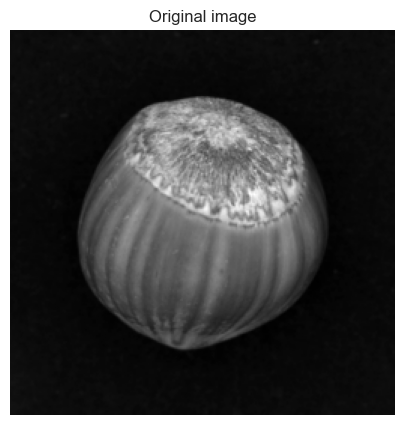

In [38]:
sample_path = random.choice(train_good)
img = load_image(sample_path)
print("Sample:", sample_path)
plt.imshow(img, cmap="gray")
plt.title("Original image")
plt.axis("off")
plt.show()


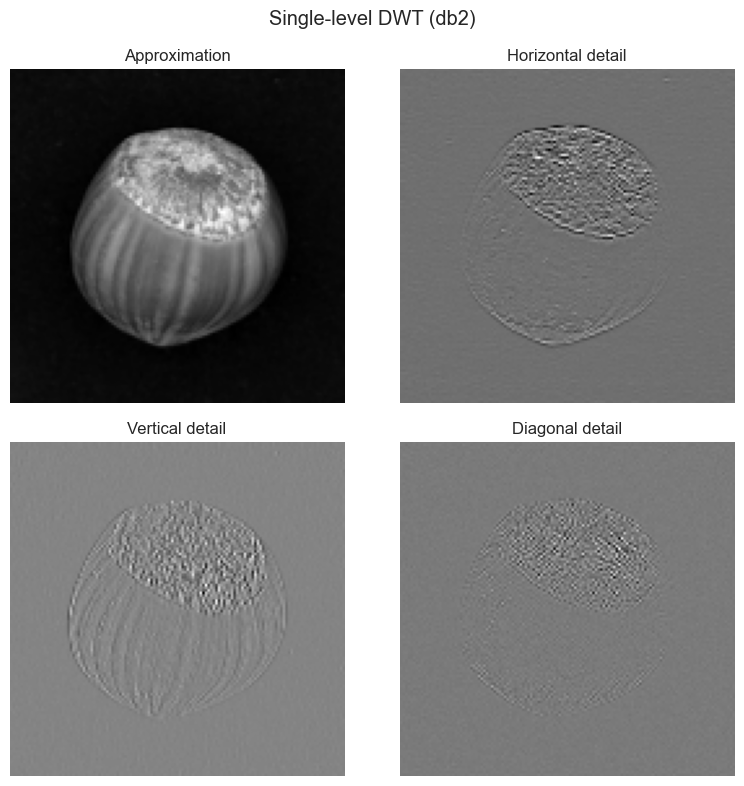

In [39]:
def normalize_display(arr):
    arr = arr - arr.min()
    if arr.max() > 0:
        arr = arr / arr.max()
    return arr

wavelet = "db2"
cA, (cH, cV, cD) = pywt.dwt2(img, wavelet)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
for ax, coeff, title in zip(
    axes,
    [cA, cH, cV, cD],
    ["Approximation", "Horizontal detail", "Vertical detail", "Diagonal detail"],
):
    ax.imshow(normalize_display(coeff), cmap="gray")
    ax.set_title(title)
    ax.axis("off")
plt.suptitle(f"Single-level DWT ({wavelet})")
plt.tight_layout()
plt.show()


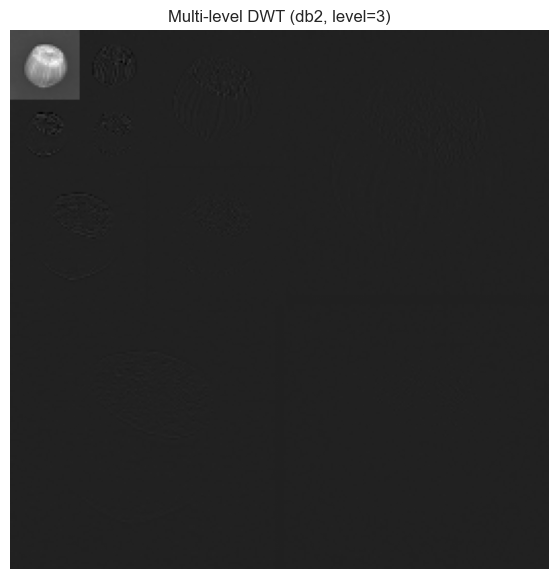

In [40]:
level = 3
coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
arr, slices = pywt.coeffs_to_array(coeffs)

plt.figure(figsize=(7, 7))
plt.imshow(normalize_display(arr), cmap="gray")
plt.title(f"Multi-level DWT ({wavelet}, level={level})")
plt.axis("off")
plt.show()


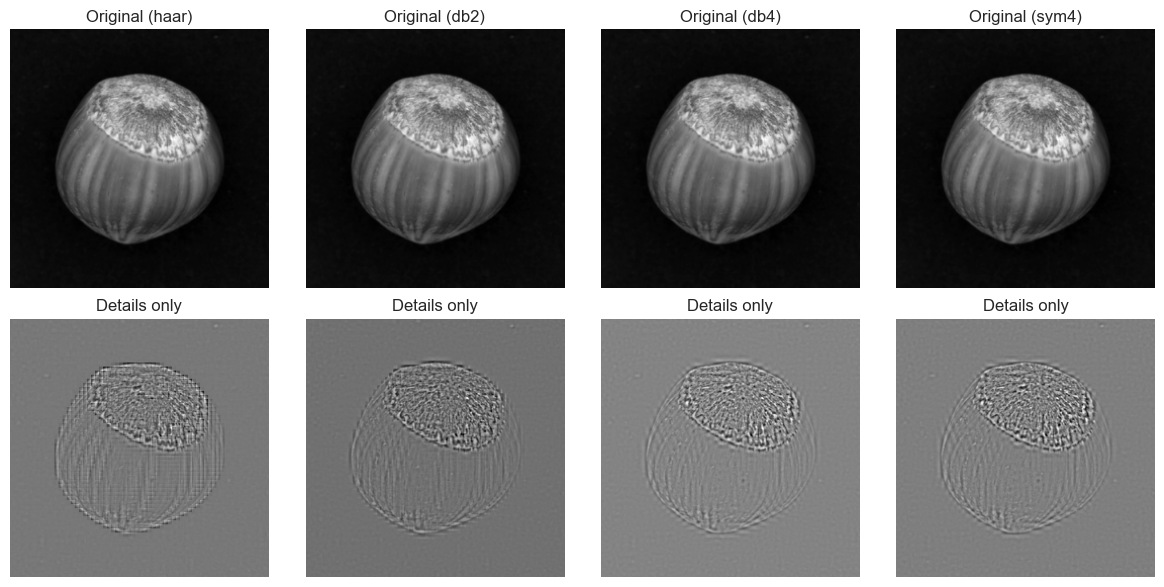

In [41]:
def reconstruct_details(image, wavelet="db2", level=2):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    approx = np.zeros_like(coeffs[0])
    details_only = [approx] + [(cH, cV, cD) for (cH, cV, cD) in coeffs[1:]]
    recon = pywt.waverec2(details_only, wavelet)
    return recon[: image.shape[0], : image.shape[1]]

wavelets = ["haar", "db2", "db4", "sym4"]
fig, axes = plt.subplots(2, len(wavelets), figsize=(3 * len(wavelets), 6))
for i, w in enumerate(wavelets):
    detail = reconstruct_details(img, wavelet=w, level=2)
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title(f"Original ({w})")
    axes[0, i].axis("off")

    axes[1, i].imshow(normalize_display(detail), cmap="gray")
    axes[1, i].set_title("Details only")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


## 3. Wavelet energy features

A simple way to summarize wavelet coefficients is the **energy** of each detail band. We will:
- Compute per-level energies for (H, V, D) detail coefficients.
- Fit a small anomaly score using only `train/good` images.
- Score `test` images and compare good vs defect.


In [42]:
def wavelet_energy_features(image, wavelet="db2", level=3, eps=1e-8):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    feats = []
    for (cH, cV, cD) in coeffs[1:]:
        for c in (cH, cV, cD):
            feats.append(np.log10(np.mean(c ** 2) + eps))
    return np.asarray(feats, dtype=np.float32)

wavelet = "db2"
level = 3

train_features = []
for path in tqdm(train_good, desc="train features"):
    image = load_image(path)
    train_features.append(wavelet_energy_features(image, wavelet=wavelet, level=level))
train_features = np.vstack(train_features)

train_features.shape


train features: 100%|██████████| 391/391 [00:18<00:00, 21.25it/s]


(391, 9)

In [43]:
def list_all_test():
    records = []
    for cls in test_classes:
        paths = list_images(TEST_DIR / cls)
        label = 0 if cls == "good" else 1
        for p in paths:
            records.append({"path": p, "class": cls, "label": label})
    return pd.DataFrame(records)


test_df = list_all_test()

test_features = []
for path in tqdm(test_df["path"], desc="test features"):
    image = load_image(path)
    test_features.append(wavelet_energy_features(image, wavelet=wavelet, level=level))

test_features = np.vstack(test_features)


test features: 100%|██████████| 110/110 [00:05<00:00, 20.50it/s]


In [44]:
median = np.median(train_features, axis=0)
mad = np.median(np.abs(train_features - median), axis=0) + 1e-6

train_scores = np.mean(np.abs((train_features - median) / mad), axis=1)

test_scores = np.mean(np.abs((test_features - median) / mad), axis=1)

threshold = np.percentile(train_scores, 95)
print(f"95th percentile threshold (train good): {threshold:.3f}")


95th percentile threshold (train good): 2.901


ROC AUC (good vs defect): 0.735


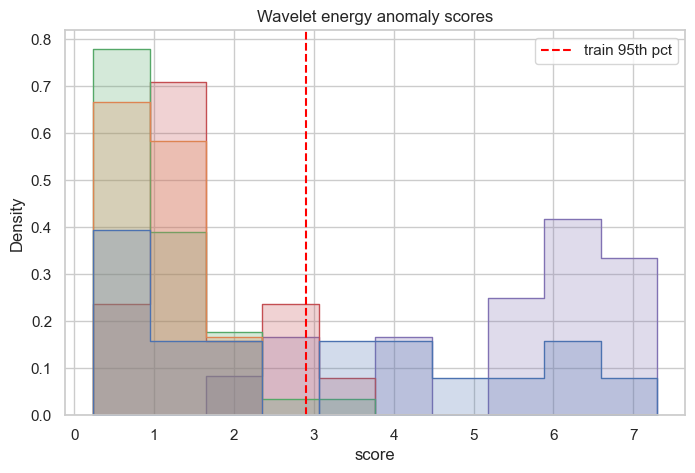

In [45]:
test_df = test_df.copy()

test_df["score"] = test_scores

if test_df["label"].nunique() > 1:
    auc = roc_auc_score(test_df["label"], test_df["score"])
    print(f"ROC AUC (good vs defect): {auc:.3f}")
else:
    print("Only one class in test set, ROC AUC not available")

plt.figure(figsize=(8, 5))
sns.histplot(data=test_df, x="score", hue="class", element="step", stat="density", common_norm=False)
plt.axvline(threshold, color="red", linestyle="--", label="train 95th pct")
plt.title("Wavelet energy anomaly scores")
plt.legend()
plt.show()


## 3.1 Anomaly scores: Good vs Bad and per-class

Here we summarize the anomaly scores two ways:
- **Good vs Bad** (all defect classes grouped together)
- **Per-class** (each defect class separately)


In [46]:
test_df = test_df.copy()

test_df["is_bad"] = test_df["class"] != "good"

good_bad_stats = (
    test_df.groupby("is_bad")["score"]
    .agg(["count", "mean", "median", "std"])
    .rename(index={False: "good", True: "bad"})
)

good_bad_stats


,count,mean,median,std
is_bad,,,,
good,40,1.069946,0.848915,0.671631
bad,70,2.736548,1.810230,2.234604


In [47]:
class_stats = (
    test_df.groupby("class")["score"]
    .agg(["count", "mean", "median", "std"])
    .sort_values("median", ascending=False)
)

class_stats


,count,mean,median,std
class,,,,
print,17,5.328387,6.157598,1.721188
crack,18,3.118278,2.842718,2.275447
hole,18,1.561799,1.370106,0.836666
cut,17,0.984377,0.972350,0.459161
good,40,1.069946,0.848915,0.671631


In [48]:
# Optional: per-defect ROC AUC vs good
auc_rows = []
for cls in sorted(test_df["class"].unique()):
    if cls == "good":
        continue
    subset = test_df[test_df["class"].isin(["good", cls])].copy()
    if subset["label"].nunique() < 2:
        continue
    auc = roc_auc_score(subset["label"], subset["score"])
    auc_rows.append({"defect_class": cls, "roc_auc_vs_good": auc})

pd.DataFrame(auc_rows).sort_values("roc_auc_vs_good", ascending=False)


,defect_class,roc_auc_vs_good
3,print,0.989706
0,crack,0.768056
2,hole,0.683333
1,cut,0.500000


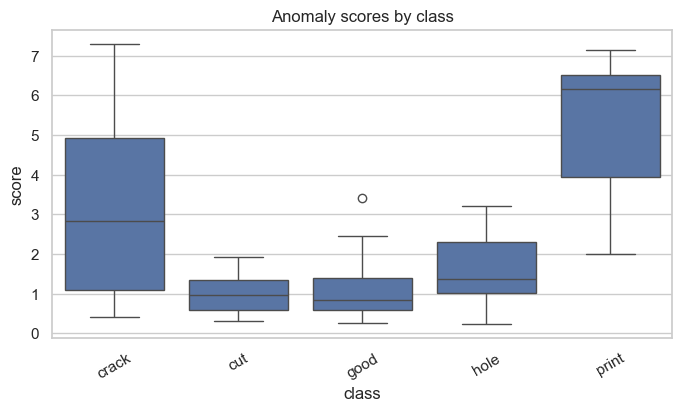

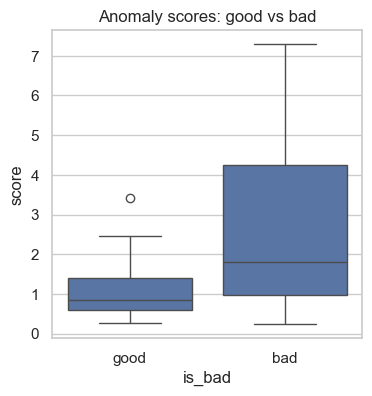

In [49]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=test_df, x="class", y="score")
plt.title("Anomaly scores by class")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(4, 4))
sns.boxplot(data=test_df, x="is_bad", y="score")
plt.title("Anomaly scores: good vs bad")
plt.xticks([0, 1], ["good", "bad"])
plt.show()


## 3.2 One-class SVM on wavelet features

We train a one-class SVM on **train/good** wavelet features and score test images. This is a classic unsupervised anomaly detector.


In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM


In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features)
X_test = scaler.transform(test_features)

# nu is an upper bound on the training error fraction
ocsvm = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale")
ocsvm.fit(X_train)

# decision_function: higher = more normal
svm_scores = ocsvm.decision_function(X_test).ravel()

# Convert to anomaly score (higher = more anomalous)
svm_anomaly = -svm_scores


In [52]:
test_df_svm = test_df.copy()

test_df_svm["svm_score"] = svm_scores
test_df_svm["svm_anomaly"] = svm_anomaly

if test_df_svm["label"].nunique() > 1:
    auc = roc_auc_score(test_df_svm["label"], test_df_svm["svm_anomaly"])
    print(f"One-class SVM ROC AUC (good vs defect): {auc:.3f}")
else:
    print("Only one class in test set, ROC AUC not available")


One-class SVM ROC AUC (good vs defect): 0.789


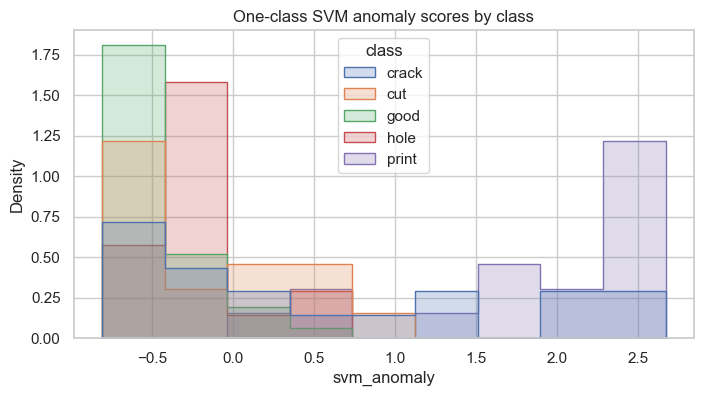

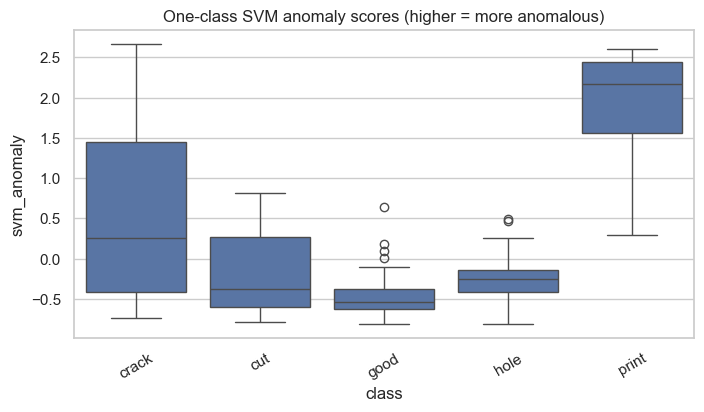

In [53]:
plt.figure(figsize=(8, 4))
sns.histplot(data=test_df_svm, x="svm_anomaly", hue="class", element="step", stat="density", common_norm=False)
plt.title("One-class SVM anomaly scores by class")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=test_df_svm, x="class", y="svm_anomaly")
plt.title("One-class SVM anomaly scores (higher = more anomalous)")
plt.xticks(rotation=30)
plt.show()


In [54]:
# Show top anomalies according to the one-class SVM
show_top_anomalies(test_df_svm.rename(columns={"svm_anomaly": "score"}), n=6)


ValueError: The column label 'score' is not unique.

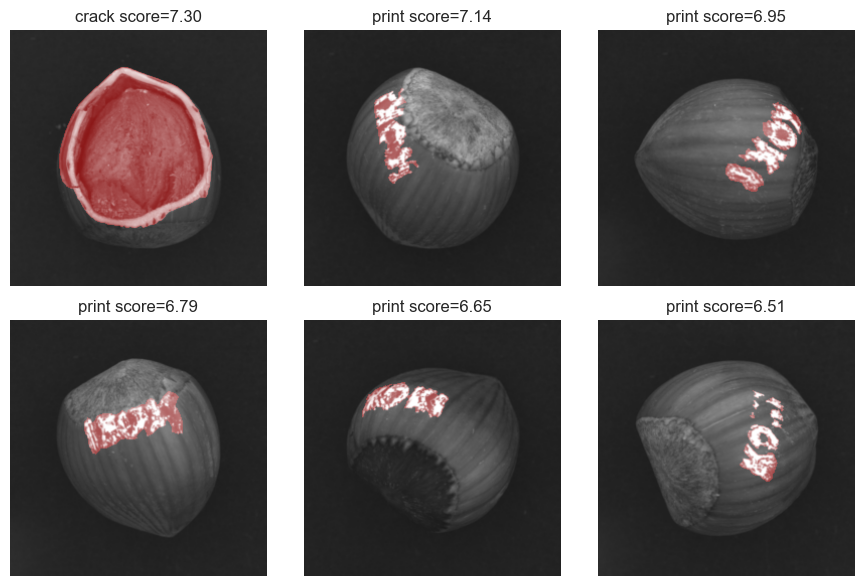

In [ ]:
def find_mask_path(img_path):
    cls = img_path.parent.name
    if cls == "good":
        return None
    mask_name = f"{img_path.stem}_mask.png"
    mask_path = GT_DIR / cls / mask_name
    return mask_path if mask_path.exists() else None


def overlay_mask(image, mask, alpha=0.5):
    rgb = np.dstack([image, image, image])
    red = rgb.copy()
    red[..., 0] = 1.0
    mask = (mask > 0.5)[..., None]
    return np.where(mask, (1 - alpha) * rgb + alpha * red, rgb)


def show_top_anomalies(df, n=6):
    top = df.sort_values("score", ascending=False).head(n)
    cols = 3
    rows = int(np.ceil(len(top) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(-1)
    for ax, (_, row) in zip(axes, top.iterrows()):
        img = load_image(row["path"])
        mask_path = find_mask_path(row["path"])
        if mask_path is not None:
            mask = load_image(mask_path, size=IMG_SIZE, gray=True)
            display = overlay_mask(img, mask)
            ax.imshow(display)
        else:
            ax.imshow(img, cmap="gray")
        ax.set_title(f"{row['class']} score={row['score']:.2f}")
        ax.axis("off")
    for ax in axes[len(top):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_top_anomalies(test_df, n=6)


## 4. Next steps

Ideas to extend this notebook:
- Try different wavelets and levels, then compare ROC AUC.
- Add spatial features: compute energy per image quadrant or patch.
- Combine wavelet features with simple texture descriptors (LBP, GLCM).
- Train a one-class model (One-Class SVM or Isolation Forest) on wavelet features.
- Use ground truth masks to evaluate how well detail coefficients align with defect areas.
